In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

In [3]:
import keras.models
import keras.layers
from keras.models import Sequential
from keras.layers import Activation, Dense

In [4]:
import numpy as np

In [5]:
dirsplit0 = "../20220408CAPSULE_DATA/splits/splitslowres/split_0/"

In [6]:
dirsplit1 = "../20220408CAPSULE_DATA/splits/splitslowres/split_1/"

In [7]:
#os.listdir(dirsplit0)

In [8]:
#os.listdir(dirsplit1)

In [7]:
train_datagen = ImageDataGenerator()

In [8]:
TRAINING_DIR = dirsplit1
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(168, 168))

Found 24100 images belonging to 11 classes.


In [9]:
validation_datagen = ImageDataGenerator()

In [10]:
VALIDATION_DIR = dirsplit0
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              target_size=(168, 168))

Found 23061 images belonging to 11 classes.


In [15]:
# for ims, labs in train_generator:
#     print(ims.shape)
#     break

## ResNet152

In [16]:
#from tensorflow.keras.applications.resnet50 import ResNet50

In [11]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_MatthewsCorrelationCoefficient', patience=3)

In [11]:
from tensorflow.keras.applications.resnet import ResNet152

In [12]:
pre_trained_model = ResNet152(input_shape=(168,168,3), include_top=False, weights= 'imagenet', pooling='avg')

2022-05-28 11:22:04.716881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:22:04.762213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:22:04.762474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:22:04.764041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:22:04.764253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [13]:
for layer in pre_trained_model.layers:  
    layer.trainable=False

In [14]:
last_layer = pre_trained_model.get_layer('conv4_block6_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 11, 11, 1024)


In [15]:
inputs = keras.layers.Input((168, 168, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs) # Preprocessing layer, normalization -1 1
x = pre_trained_model(x)

## Aquestes capes son opcionals
x = keras.layers.Dropout(0.4)(x)      
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)   

out = keras.layers.Dense(11, activation='softmax')(x)           
model = keras.Model(inputs=inputs, outputs=out) 

model.compile(optimizer = tf.optimizers.SGD(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                       tfa.metrics.F1Score(num_classes=11, average="micro"), 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       tfa.metrics.MatthewsCorrelationCoefficient(num_classes=11)])


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 168, 168, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 168, 168, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 168, 168, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [17]:
history_resnet = model.fit(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/30


2022-05-28 11:22:45.593978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


754/754 [==============================] - 575s 745ms/step - loss: 0.9191 - categorical_accuracy: 0.7628 - f1_score: 0.7628 - precision: 0.8175 - recall: 0.7130 - MatthewsCorrelationCoefficient: 0.2537 - val_loss: 1.2442 - val_categorical_accuracy: 0.6992 - val_f1_score: 0.6992 - val_precision: 0.7317 - val_recall: 0.6787 - val_MatthewsCorrelationCoefficient: 0.2162
Epoch 2/30
754/754 [==============================] - 554s 735ms/step - loss: 0.6616 - categorical_accuracy: 0.8096 - f1_score: 0.8096 - precision: 0.8605 - recall: 0.7654 - MatthewsCorrelationCoefficient: 0.4342 - val_loss: 1.1900 - val_categorical_accuracy: 0.6999 - val_f1_score: 0.6999 - val_precision: 0.7455 - val_recall: 0.6710 - val_MatthewsCorrelationCoefficient: 0.2353
Epoch 3/30
754/754 [==============================] - 554s 735ms/step - loss: 0.5881 - categorical_accuracy: 0.8281 - f1_score: 0.8281 - precision: 0.8728 - recall: 0.7853 - MatthewsCorrelationCoefficient: 0.5031 - val_loss: 1.1914 - val_categorical_a

Epoch 23/30
754/754 [==============================] - 554s 735ms/step - loss: 0.3077 - categorical_accuracy: 0.9069 - f1_score: 0.9069 - precision: 0.9251 - recall: 0.8905 - MatthewsCorrelationCoefficient: 0.7527 - val_loss: 1.3223 - val_categorical_accuracy: 0.6910 - val_f1_score: 0.6910 - val_precision: 0.7327 - val_recall: 0.6700 - val_MatthewsCorrelationCoefficient: 0.2647
Epoch 24/30
754/754 [==============================] - 554s 735ms/step - loss: 0.3074 - categorical_accuracy: 0.9057 - f1_score: 0.9057 - precision: 0.9239 - recall: 0.8900 - MatthewsCorrelationCoefficient: 0.7495 - val_loss: 1.3197 - val_categorical_accuracy: 0.6909 - val_f1_score: 0.6909 - val_precision: 0.7320 - val_recall: 0.6683 - val_MatthewsCorrelationCoefficient: 0.2656
Epoch 25/30
754/754 [==============================] - 554s 735ms/step - loss: 0.2972 - categorical_accuracy: 0.9101 - f1_score: 0.9101 - precision: 0.9279 - recall: 0.8938 - MatthewsCorrelationCoefficient: 0.7615 - val_loss: 1.2925 - val

In [18]:
# evaluate the model
loss, accuracy, f1_score, precision, recall, MCC = model.evaluate(validation_generator, verbose=0)

In [19]:
print ("loss =",loss,"accuracy=",accuracy,"f1=",f1_score,"precision",precision,"recall",recall,"MCC",MCC)

loss = 1.311339020729065 accuracy= 0.6898660063743591 f1= 0.6898660063743591 precision 0.7337906956672668 recall 0.6679242253303528 MCC 0.27224239706993103


In [20]:
model.save('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220517PereGilabert/152train1lowres30epochmodelsaved')

2022-05-28 16:46:40.976369: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220517PereGilabert/152train1lowres30epochmodelsaved/assets


In [ ]:
#model = keras.models.load_model('/home/javier/Documents/dsub/20220408CAPSTONE_CAPSULE/20220517PereGilabert/152train1lowres30epochmodelsaved')

In [21]:
history_resnet.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'f1_score', 'precision', 'recall', 'MatthewsCorrelationCoefficient', 'val_loss', 'val_categorical_accuracy', 'val_f1_score', 'val_precision', 'val_recall', 'val_MatthewsCorrelationCoefficient'])

In [22]:
ac = history_resnet.history['categorical_accuracy']
v_ac = history_resnet.history['val_categorical_accuracy']   
lo = history_resnet.history['loss']
v_lo = history_resnet.history['val_loss']
f = history_resnet.history['f1_score']
v_f = history_resnet.history['val_f1_score']
mcc = history_resnet.history['MatthewsCorrelationCoefficient']
v_mcc = history_resnet.history['val_MatthewsCorrelationCoefficient']
epochs = history_resnet.epoch

Text(0, 0.5, 'Accuracy')

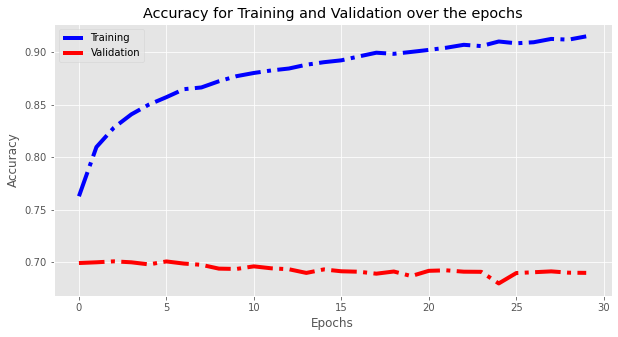

In [23]:
plt.figure(figsize=(10,5),frameon=False)
plt.plot(epochs,ac,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_ac,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Accuracy for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

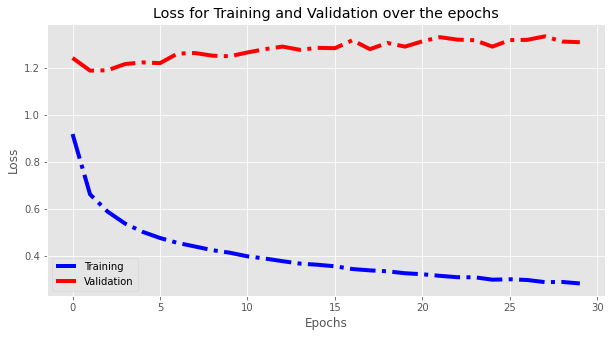

In [24]:
plt.figure(figsize=(10,5))
plt.plot(epochs,lo,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_lo,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Loss for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'f1')

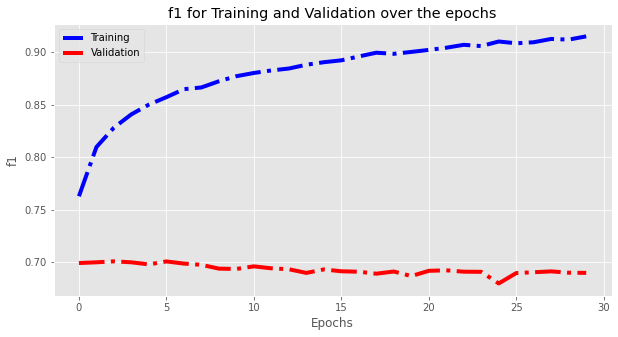

In [25]:
plt.figure(figsize=(10,5))
plt.plot(epochs,f,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_f,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('f1 for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('f1')

Text(0, 0.5, 'MCC')

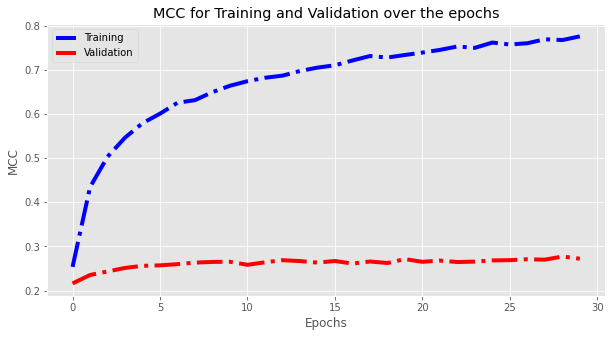

In [26]:
plt.figure(figsize=(10,5))
plt.plot(epochs,mcc,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_mcc,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('MCC for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('MCC')